<a href="https://colab.research.google.com/github/gaurav-034/csmi17assignment/blob/main/AI_Assignment_P2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import time, random, math, heapq, os, pathlib
import pandas as pd
import matplotlib.pyplot as plt

class Course:
    def __init__(self, name, teacher, students):
        self.name, self.teacher, self.students = name, teacher, students

class Room:
    def __init__(self, name, capacity):
        self.name, self.capacity = name, capacity

def generate_instance(seed=None):
    if seed: random.seed(seed)
    teachers = [f'T{i}' for i in range(5)]
    rooms = [Room(f'R{j}', random.randint(20,60)) for j in range(3)]
    timeslots = [f'S{k}' for k in range(5)]
    courses = [Course(f'C{i}', random.choice(teachers), random.randint(10,50)) for i in range(8)]
    return courses, teachers, rooms, timeslots

def backtracking_mrv_lcv(courses, rooms, timeslots):
    domains = {c.name:[(s,r.name) for s in timeslots for r in rooms if c.students <= r.capacity] for c in courses}
    teacher = {c.name:c.teacher for c in courses}
    assignment, nodes, assignments_count = {}, 0, 0

    def select_var():
        unassigned = [v for v in domains if v not in assignment]
        return min(unassigned, key=lambda v: len(domains[v]))

    def consistent(v, val):
        s,r = val
        for ov, oval in assignment.items():
            if oval[0]==s and oval[1]==r: return False
            if teacher[ov]==teacher[v] and oval[0]==s: return False
        return True

    def backtrack():
        nonlocal nodes, assignments_count
        nodes += 1
        if len(assignment)==len(courses): return True
        var = select_var()
        for val in domains[var]:
            if consistent(var,val):
                assignment[var]=val
                assignments_count += 1 # Increment assignment count
                if backtrack(): return True
                del assignment[var]
        return False

    t0=time.perf_counter()
    solv=backtrack()
    return {'solvable':solv,'nodes':nodes,'assignments':assignments_count,'time':time.perf_counter()-t0}

def backtracking_forward_checking(courses, rooms, timeslots):
    domains = {c.name:[(s,r.name) for s in timeslots for r in rooms if c.students <= r.capacity] for c in courses}
    teacher = {c.name:c.teacher for c in courses}
    assignment, nodes, assignments_count = {}, 0, 0

    def select_var():
        for c in courses:
            if c.name not in assignment:
                return c.name

    def consistent(v, val):
        s,r = val
        for ov, oval in assignment.items():
            if oval[0]==s and oval[1]==r: return False
            if teacher[ov]==teacher[v] and oval[0]==s: return False
        return True

    def forward_check(v, val, local_domains):
        s,r = val
        new_domains = {k:list(vs) for k,vs in local_domains.items()} # Create a copy for pruning
        for other in [c.name for c in courses if c.name not in assignment and c.name!=v]:
            for vv in local_domains[other]: # Iterate over original domain
                 # If the value is inconsistent with the new assignment, remove it from the copied domain
                if (vv[0]==s and vv[1]==r) or (teacher[other]==teacher[v] and vv[0]==s):
                    if vv in new_domains[other]: # Check if the value is still in the copied domain before removing
                        new_domains[other].remove(vv)
            if not new_domains[other]: return None # If any domain becomes empty, return None
        return new_domains

    def backtrack(domains_local):
        nonlocal nodes, assignments_count
        nodes += 1
        if len(assignment)==len(courses): return True
        var=select_var()
        for val in domains_local[var]:
            if consistent(var,val):
                assignment[var]=val
                assignments_count += 1 # Increment assignment count
                # Apply forward checking and get the new domains
                new_domains = forward_check(var, val, domains_local)
                if new_domains is not None: # If forward checking succeeded
                    if backtrack(new_domains): return True
                del assignment[var] # Backtrack: remove assignment and restore domains (implicitly by not using new_domains)
        return False

    t0=time.perf_counter()
    solv=backtrack(domains) # Start backtracking with the initial domains
    return {'solvable':solv,'nodes':nodes,'assignments':assignments_count,'time':time.perf_counter()-t0}

In [ ]:
# Run CSP
out_dir = 'ai_assignment_output'
os.makedirs(out_dir, exist_ok=True)
rows=[]
for i in range(30):
    c,tch,r,ts = generate_instance(i)
    r1=backtracking_mrv_lcv(c,r,ts)
    r2=backtracking_forward_checking(c,r,ts)
    rows.append({'trial':i,'mrv_nodes':r1['nodes'],'fc_nodes':r2['nodes'],'mrv_assignments':r1['assignments'],'fc_assignments':r2['assignments'],'mrv_time':r1['time'],'fc_time':r2['time']})
df_csp=pd.DataFrame(rows)
df_csp.to_csv(os.path.join(out_dir,'csp_results.csv'),index=False)

print('All results saved to:', out_dir)

All results saved to: ai_assignment_output


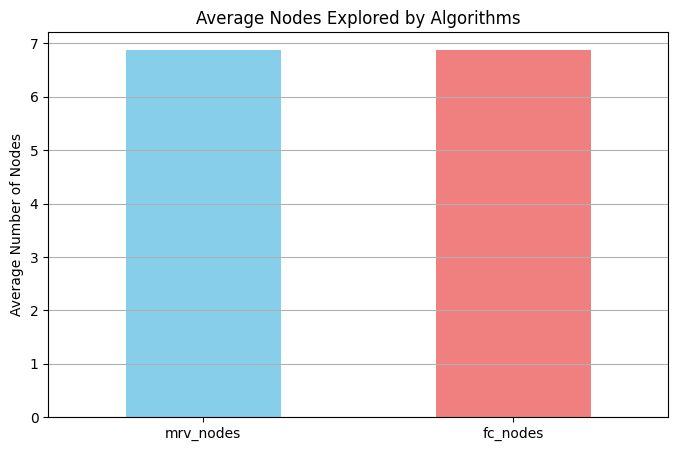

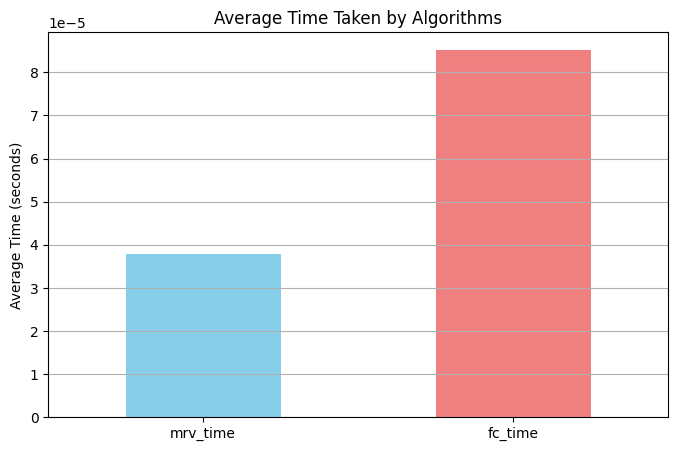

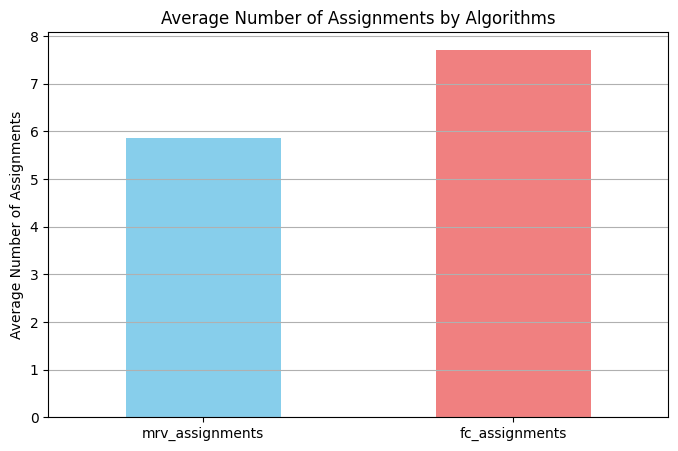

In [ ]:
# Calculate average nodes, time, and assignments
avg_nodes = df_csp[['mrv_nodes', 'fc_nodes']].mean()
avg_time = df_csp[['mrv_time', 'fc_time']].mean()
avg_assignments = df_csp[['mrv_assignments', 'fc_assignments']].mean()

# Create bar chart for nodes
plt.figure(figsize=(8, 5))
avg_nodes.plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Average Nodes Explored by Algorithms')
plt.ylabel('Average Number of Nodes')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

# Create bar chart for time
plt.figure(figsize=(8, 5))
avg_time.plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Average Time Taken by Algorithms')
plt.ylabel('Average Time (seconds)')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

# Create bar chart for assignments
plt.figure(figsize=(8, 5))
avg_assignments.plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Average Number of Assignments by Algorithms')
plt.ylabel('Average Number of Assignments')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()